<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Doggies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
!pip install --upgrade --force-reinstall --no-deps kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"
!kaggle competitions download dog-breed-identification
!unzip "/content/dog-breed-identification"

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp36-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/dog-breed-identification.zip
replace labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install --upgrade fastai
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision.all import *
from fastai import *
import random

In [7]:
labels = pd.read_csv('/content/labels.csv')
def label_func(fname):
    return labels.loc[labels.id == fname.name[:-4], 'breed'].item()

path = Path('/content/train/')

In [32]:
import random
removed_samples = random.sample(path.ls(), 5000)

In [33]:
for doggie in removed_samples:
  doggie.unlink()

In [34]:
path.ls()

(#4122) [Path('/content/train/e87a86f29c8709e81bbea9c8139d739c.jpg'),Path('/content/train/35e495b1de348a81e9c64f929de8beff.jpg'),Path('/content/train/be32d9afea6b7ddb96724df1e617873d.jpg'),Path('/content/train/329cc823101c76d6f7c066d05f02d5e2.jpg'),Path('/content/train/62fded7400b95ead880f6f7ab61be90a.jpg'),Path('/content/train/fc4f1d94ed5191b9b7d1f24420bbb07b.jpg'),Path('/content/train/f58531d21504bc086aa5d0e2c945f988.jpg'),Path('/content/train/416f36e236378210a7b553c0717950d1.jpg'),Path('/content/train/e7f2f67cb616281a89fc77a6bdea6eb0.jpg'),Path('/content/train/404db576fb2006cfd1aed0f5683b786e.jpg')...]

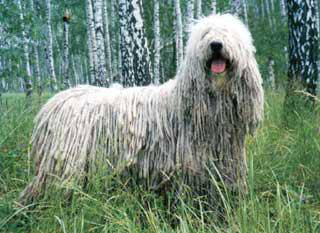

In [35]:
Image.open(path.ls()[1002])

In [57]:
dogs = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_y = label_func,
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, mult=2, min_scale=0.5, flip_vert = True))

dls = dogs.dataloaders(path, batch_size = 150)
#dls = dogs.dataloaders(temp_path, batch_size = 150)
#batch_tfms = aug_transforms(size=224, mult=2, min_scale=0.5))

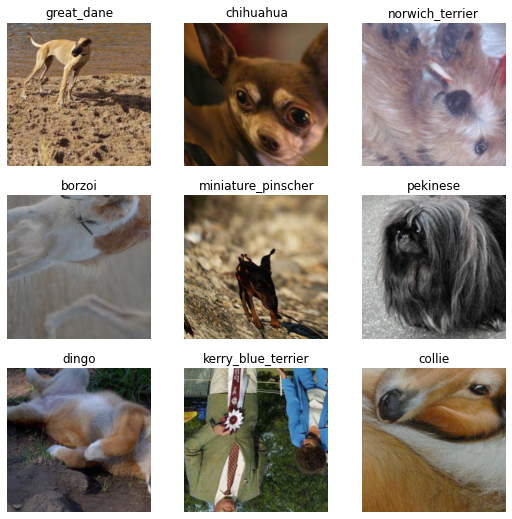

In [58]:
dls.show_batch()
 

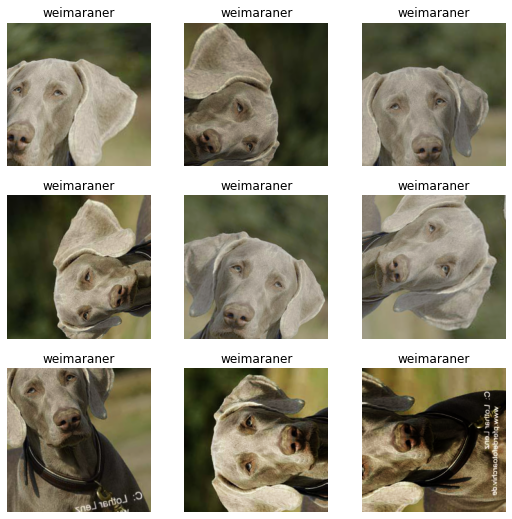

In [59]:
dls.train.show_batch(unique= True)

In [65]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy()).to_fp16()

In [66]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,5.095299,2.080608,0.629854,00:36


epoch,train_loss,valid_loss,accuracy,time
0,3.031640,1.725454,0.746359,00:38
1,2.782169,1.607330,0.808252,00:37
2,2.598783,1.627837,0.814320,00:38
3,2.442562,1.655453,0.775485,00:38
4,2.312682,1.676115,0.754854,00:38
5,2.189178,1.652626,0.785194,00:38
6,2.091706,1.583089,0.790049,00:38
7,1.996437,1.569583,0.807039,00:38
8,1.889418,1.562579,0.800971,00:38
9,1.794904,1.527642,0.810680,00:38


In [71]:
test_path = Path('/content/test/')
tst_files = get_image_files(test_path)
tst_dl = dls.test_dl(tst_files)

In [72]:
predictions = learn.tta(dl = tst_dl)

In [73]:
sub = pd.DataFrame(predictions[0].numpy())
sub.columns = learn.dls.vocab
sub.insert(0, column = 'id', value = [x.name[:-4] for x in test_path.ls()])

In [74]:
sub.to_csv('submission.csv', index=False)

In [79]:
!kaggle competitions submit -f /content/submission.csv -m something dog-breed-identification

100% 16.1M/16.1M [00:00<00:00, 23.2MB/s]
Successfully submitted to Dog Breed Identification